In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import sys
sys.path.insert(0, '/home/riccardo/Desktop/OcclusionInference/Architectures')
from data_loaders.dataset_unsup import MyDataset_unsup


# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)



%matplotlib inline
%load_ext autoreload
%autoreload 2

Random Seed:  999


In [29]:
#Root directory for dataset
dataroot = "/home/riccardo/Desktop/Data/better_100k_bw_ro/digts/"

# Number of workers for dataloader
workers = 8

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 25

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.8

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [30]:
train_image_paths = "{}train/orig/".format(dataroot)
train_target_paths = "{}train/inverse/".format(dataroot)
train_data_size = len(os.listdir(train_image_paths))
train_data = MyDataset_unsup(train_image_paths, train_target_paths, image_size, 'train', train_data_size)

dataloader = torch.utils.data.DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=workers,
                              pin_memory=True,
                              drop_last=False)

Sorting train image files


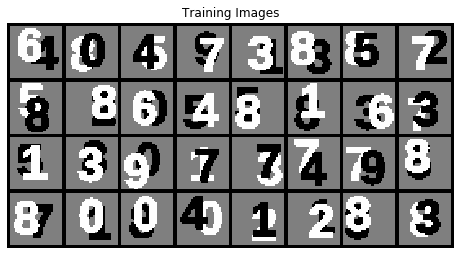

In [31]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))['x']
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [32]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [33]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [34]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(25, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [35]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(nc, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [36]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [37]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [38]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        
        real_cpu = data['x'].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/10][0/782]	Loss_D: 1.4862	Loss_G: 18.7358	D(x): 0.4989	D(G(z)): 0.4795 / 0.0000
[0/10][50/782]	Loss_D: 0.0173	Loss_G: 7.2454	D(x): 0.9891	D(G(z)): 0.0040 / 0.0015
[0/10][100/782]	Loss_D: 0.0304	Loss_G: 10.2743	D(x): 0.9849	D(G(z)): 0.0058 / 0.0007
[0/10][150/782]	Loss_D: 0.2866	Loss_G: 10.0371	D(x): 0.9377	D(G(z)): 0.1011 / 0.0003
[0/10][200/782]	Loss_D: 0.2070	Loss_G: 9.2677	D(x): 0.9334	D(G(z)): 0.0742 / 0.0005
[0/10][250/782]	Loss_D: 0.0887	Loss_G: 15.1200	D(x): 0.9990	D(G(z)): 0.0372 / 0.0004
[0/10][300/782]	Loss_D: 0.0791	Loss_G: 9.4361	D(x): 0.9605	D(G(z)): 0.0060 / 0.0005
[0/10][350/782]	Loss_D: 0.0394	Loss_G: 13.2241	D(x): 0.9762	D(G(z)): 0.0001 / 0.0001
[0/10][400/782]	Loss_D: 0.0750	Loss_G: 6.7571	D(x): 0.9942	D(G(z)): 0.0554 / 0.0078
[0/10][450/782]	Loss_D: 0.3011	Loss_G: 6.0615	D(x): 0.8659	D(G(z)): 0.0345 / 0.0157
[0/10][500/782]	Loss_D: 0.1811	Loss_G: 6.0224	D(x): 0.9514	D(G(z)): 0.0868 / 0.0138
[0/10][550/782]	Loss_D: 0.1213	Loss_G: 8.4563	D(

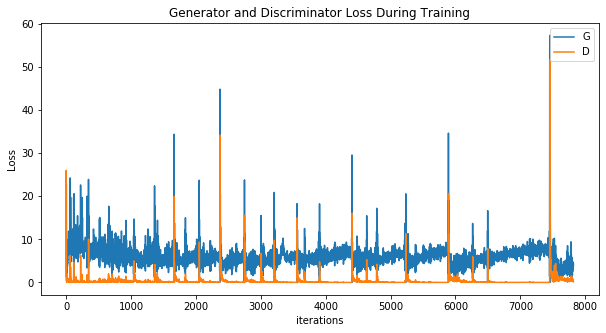

In [39]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


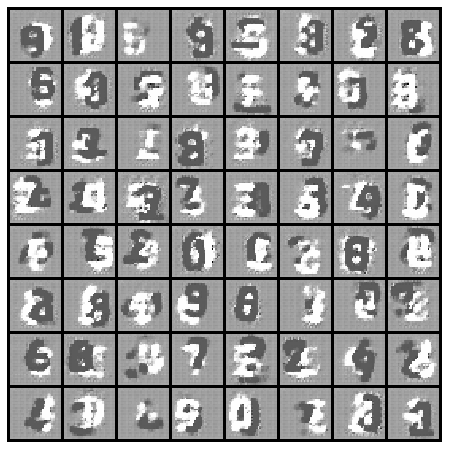

In [40]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

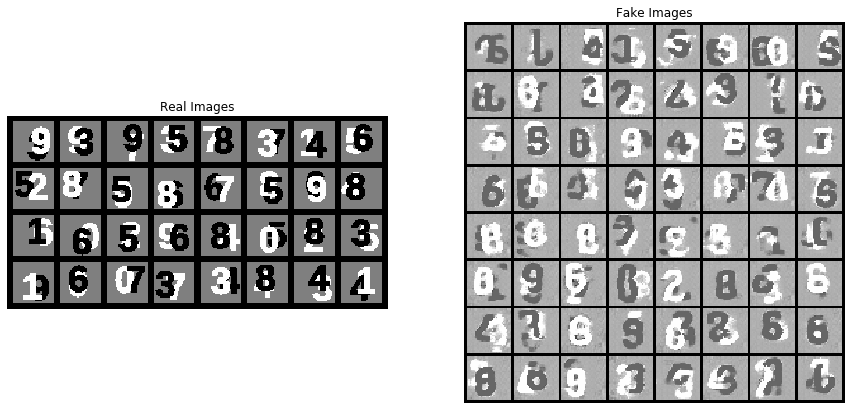

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch['x'].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


In [101]:
fixed_noise[8,:,0,0].view(1,-1).shape

torch.Size([1, 25])

In [102]:
import torchvision
import imageio
import shutil


num_frames = 100
global_iter = 10
ID= 0
output_dir =  "/home/riccardo/Desktop"
z_dim = nz
z_sample = fixed_noise[8,:,0,0].view(1,-1).cpu()

print(z_sample.shape)

num_slice = int(1000/num_frames)
dist_samples = np.random.normal(loc=0, scale=1, size=1000)
dist_samples.sort()
dist_samples = torch.from_numpy(dist_samples[0::num_slice])
print(torch.ones(num_frames*z_dim,1).shape)
traverse_input = torch.mul(torch.ones(num_frames*z_dim,1),z_sample)

print(traverse_input.shape)
indexs = np.arange(0, num_frames*z_dim, num_frames)
for i in indexs:
    z = int(i/num_frames)
    traverse_input[i:(i+num_frames),z] = dist_samples

traverse_input = traverse_input.unsqueeze(2)
traverse_input = traverse_input.unsqueeze(2)
traverse_input = traverse_input.to(device)
print(traverse_input.shape)




reconst = netG(traverse_input).detach().cpu()
    
indexs = np.arange(0, num_frames*z_dim, num_frames)
for i in indexs:
    #save images for each gif into the images list
    images = []
    for e in range(num_frames):
        #save images to make gifs into different folders
        filename = '{}/traversals{}_{}/z{}/img{}.png'.format(output_dir,global_iter,ID,int(i/num_frames),e)
        directory = os.path.dirname(filename)
        if not os.path.exists(directory):
            os.makedirs(directory)
        torchvision.utils.save_image(reconst[i+e,0,:,:].cpu() , filename)
        images.append(imageio.imread(filename))


    #save all gifs into same folder
    filename_2 = '{}/traversals_gifs{}_{}/traversing_z_{}.gif'.format(
        output_dir,global_iter, ID,int(i/num_frames),int(i/num_frames))
    directory_2 = os.path.dirname(filename_2)
    if not os.path.exists(directory_2):
            os.makedirs(directory_2)
    imageio.mimsave('{}/traversals_gifs{}_{}/traversing_z_{}.gif'.format(
        output_dir, global_iter, ID, int(i/num_frames),int(i/num_frames)), images)

    with open('{}/traversals_gifs{}_{}/encoded_z.txt'.format(output_dir,global_iter,ID), 'w') as f:
        f.write(str(z_sample.numpy()))

    shutil.rmtree(directory)

torch.Size([1, 25])
torch.Size([2500, 1])
torch.Size([2500, 25])
torch.Size([2500, 25, 1, 1])
